<html>
<h1 style = "text-align : center; border : 1px black solid; padding : 20px;"> DL. Task 2. CNN</h1>

<h5 style = "text-align : right;">Louis Salomé</h5>

<br>Here are the main parts of this notebook :
1. Load Fashion MNIST from keras.datasets
2. Train MLP and Random Forest on Fashion MNIST. For MLP use parameters search via grid search or random search
3. Train CNN on Fashion MNIST with parameters search
4. Train CNN autoencoder on Fashion MNIST with parameters search
5. Train MLP and Random Forest on the latent vector from TRAINED CNN autoencoder
6. Compare all results using plot/plots

In [1]:
### import part

# Process data
import numpy as np

# Plot graphics
import matplotlib
from matplotlib import pyplot as plt
from pprint import pprint

# Measure time
import time
from time import time

#Simulate randomness
import random as rd

# Load Data
import keras
from keras.datasets.fashion_mnist import load_data

# Read Images
import skimage
from skimage.io import imread

# Model selection
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Neural Networks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

# tensorflow
import tensorflow as tf

# grid search optimization
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

# Use only one of the 4 GPUs
# Using the command nvidia-sim we can chose the freest GPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Here is the NUMBER_OF_GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


# 1. The Fashion MNIST Dataset

This is a MNIST-like dataset from keras of 70,000 28x28 labeled fashion images. 
Its size is 69MB. 
It is labeled with 10 classes (from 0 to 9).

In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
size = x_train.shape[0]
x_train = x_train[:size]
y_train = y_train[:size]
x_test = x_test[:int(size/2)]
y_test = y_test[:int(size/2)]

In [4]:
# get its shape
input_shape = x_train.shape
[m    ,h,w] = x_train.shape
[mtest,h,w] = x_test.shape

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = keras.utils.normalize(x_train,axis=1)
x_test = keras.utils.normalize(x_test,axis=1)

x_train = np.reshape(x_train, (m, h*w)) 
x_test = np.reshape(x_test, (mtest, h*w))
y_train = np.reshape(y_train, (m, 1))
y_test = np.reshape(y_test, (mtest, 1))

print("x_train shape:", x_train.shape, "\nx_test shape :", x_test.shape)

x_train shape: (60000, 784) 
x_test shape : (10000, 784)


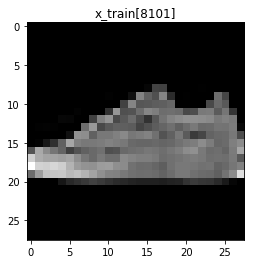

In [5]:
# how does a sample look like ?
r = rd.randint(1,m)
plt.imshow(x_train[r].reshape((h,w)),cmap='gray')
plt.title("x_train["+str(r)+']')
plt.show()

# 2. MLP & RF and Tuning Hyperparameters

In this part we try two different classifiers : the RandomForestClassifier from sklearn.ensemble and a Multilayer Perceptron with our own architecure.

For both of them we will first try to fit a base_model, then do a random search to find quite good parameters, and then do a grid_search to fine better ones. Code inspired from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## 2.1 RandomForestClassifier

### 2.1.1 A small forest

In [7]:
# initialize
rf_base_model = RandomForestClassifier()

# fit
start=time()
rf_base_model.fit(x_train, y_train.ravel())
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

# predict
y_predict = rf_base_model.predict(x_test)
acc = accuracy_score(y_test.ravel(), y_predict, normalize=True)
print("We found an accuracy of",round(100*acc,2),"%.")

Elapsed time for fitting :  9.97 secondes.
We found an accuracy of 85.1 %.


### 2.1.2 Tuning hyperparameters of RandomForectClassifier by Random Search

Random search allows us to narrow down the range for each hyperparameter. We will tune parameters such as :
+ number of estimators
+ maximum of features
+ maximum depth
+ minimum samples for a split
+ minimume samples in a leaf
+ use bootstrap ?

In [8]:
# searching space
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 8)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 80, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
print("This is the grid we're gonna use :")
pprint(random_grid)

This is the grid we're gonna use :
{'bootstrap': [True, False],
 'max_depth': [10, 27, 45, 62, 80, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 88, 157, 225, 294, 362, 431, 500]}


In [ ]:
Niter = 5
k_cv = 3

start=time()
# random search
rf_random = RandomizedSearchCV(
    estimator = RandomForestClassifier(), 
    param_distributions = random_grid, 
    n_iter = Niter, 
    cv = k_cv,
    verbose=2
)

# Fit the random search model
rf_random.fit(x_train, y_train.ravel())

# results
print("Elapsed time for random search with",Niter,"iterations : ", round(time()-start,2),"secondes.")
print("This is the best parameters we found :")
rf_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=80, min_samples_leaf=4, n_estimators=362, max_features=sqrt, min_samples_split=5, bootstrap=True 
[CV]  max_depth=80, min_samples_leaf=4, n_estimators=362, max_features=sqrt, min_samples_split=5, bootstrap=True, total= 3.3min
[CV] max_depth=80, min_samples_leaf=4, n_estimators=362, max_features=sqrt, min_samples_split=5, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


### 2.1.3 Grid Search

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

In [ ]:
# grid
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2, 3],
    'n_estimators': [200,250,300]
}

pprint(param_grid)

In [ ]:
# how many folds in the cross-validation ?
k_cv = 3

start=time()
rf_grid = GridSearchCV(
    estimator = RandomForestClassifier(), 
    param_grid = param_grid, 
    cv = k_cv,
    verbose = 2
    #n_jobs = -1, 
)

# Fit the grid search to the data
rf_grid.fit(x_train, y_train)

print("Elapsed time for grid search : ", round(time()-start,2),"secondes.")
rf_grid.best_params_

### 2.1.4 How efficient was the tuning ?

Let's compare the results.

In [ ]:
def evaluate(model, x_test, y_test):
    y_predict = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_predict, normalize=True)
    print('Model Performance')
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
# rf_base_model
rf_base_accuracy = evaluate(rf_base_model, x_test, y_test)

#rf_random_search
rf_best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)
print('Improvement between base and random of {:0.2f}%.'.format( 100 * (rf_random_accuracy - rf_base_accuracy) / base_accuracy))

# rf_grid_search
rf_best_grid = rf_grid.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)
print('Improvement between grid and random of {:0.2f}%.'.format( 100 * (rf_grid_accuracy - rf_random_accuracy) / base_accuracy))

## 2.2 MLP

### 2.2.1 A first MLP

In [ ]:
# initialize
MLP_base_model = Sequential()
MLP_base_model.add(Dense(64, activation=tf.nn.relu, input_dim=h*w))
MLP_base_model.add(Dense(64, activation=tf.nn.relu))
MLP_base_model.add(Dense(10, activation=tf.nn.softmax))

# Compilation
MLP_base_model.compile(
              optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_hinge',
              metrics=['accuracy'])
# model will be our mlp for the whole lab

# Training
start = time()
MLP_base_model.fit(x_train, keras.utils.np_utils.to_categorical(y_train), epochs=20, batch_size=128, verbose = 0)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

# Predicting
y_predict_onehot = MLP_base_model.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
# Calculating accuracy
MLP_base_model_acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*MLP_base_model_acc,2),"%.")

### 2.2.2 Tuning hyperparameters of MLP by Random Search

Now we do the same as before with a neural network. This NN will be a MLP. 
We will try to tune some parameters such as :
+ learning rate
+ optimizer
+ activation function
+ depth of the network for MLP

Code inspired from : https://github.com/keras-team/keras/issues/1591

In [ ]:
# searching space
learning_rate = [0.004, 0.002, 0.001, 0.0005]
optimizer = ['adadelta','adam','rmsprop']
activation_function = ["relu","elu","selu"]
activation_function_last = ["softmax"]
depth = [2,3,4,5]
epochs = [20,30]

# grid
random_grid = {
    'learning_rate': hp.choice('learning_rate',learning_rate),
    'optimizer':  hp.choice('optimizer',optimizer),
    'activation_function': hp.choice('activation_function',activation_function),
    'activation_function_last': hp.choice('activation_function_last',activation_function_last),
    'depth': hp.choice('depth',depth),
    'epochs': hp.choice('epochs',epochs)
}

In [ ]:
# function to build a model for a given set of parameters
def testMLP(params):
    
    # initialize
    model = Sequential()
    
    # set depth
    for i in range(params['depth'] -1):
        model.add(Dense(64, 
                      activation=params['activation_function']) # set activation function
               )
    model.add(Dense(10, activation=params['activation_function_last']))
    
    # set optimizer
    if params["optimizer"]=="adam":
        # default lr = 0.001
        this_optimizer = keras.optimizers.Adam(lr=params['learning_rate'])
    if params["optimizer"]=="adadelta":
        # default lr = 1
        this_optimizer = keras.optimizers.Adadelta(lr=100*params['learning_rate'])
    if params["optimizer"]=="rmsprop":
        # default lr = 0.002
        this_optimizer = keras.optimizers.RMSprop(lr=2*params['learning_rate'])
    
    
    # compile 
    model.compile(optimizer = this_optimizer,
                  loss='categorical_hinge',
                  metrics=['accuracy'])
    
    # fit
    model.fit(x_train, 
              keras.utils.np_utils.to_categorical(y_train), 
              epochs=params['epochs'], 
              batch_size=128, 
              verbose = 0)
    
    # Predicting
    y_predict_onehot = model.predict([x_test])
    y_predict = np.zeros(mtest)
    for i in range(mtest):
        y_predict[i] = np.argmax(y_predict_onehot[i])

    # Calculating accuracy
    acc = accuracy_score(y_predict,y_test)

    # display some informations
    def printinfo():
        print("*****************")
        print(" learning rate            :", params['learning_rate'],"\n",
              "optimizer                :", params['optimizer'],"\n",
              "activation function      :", params['activation_function'],"\n",
              "activation function last :", params['activation_function_last'],"\n",
              "depth                    :", params['depth'],"\n",
              "epochs                   :", params['epochs'])
        print(">>>> acc =",round(100*acc,2),"%.\n")
        pass
    printinfo()
    
    # return loss
    return {'loss': -acc, 'status': STATUS_OK}

In [ ]:
Niter = 20

start = time()
trials = Trials()
best = fmin(testMLP, 
            random_grid, 
            algo=tpe.suggest, 
            max_evals=Niter, 
            trials=trials)
print("Elapsed time for random search with",Niter,"iterations : ", round(time()-start,2),"secondes.")

In [ ]:
bestparams_random = {
    'learning_rate': learning_rate[best['learning_rate']],
    'optimizer':  optimizer[best['optimizer']],
    'activation_function': activation_function[best['activation_function']],
    'depth': depth[best['depth']],
    'epochs': epochs[best['epochs']]
}
pprint(bestparams_random)

MLP_best_random_acc = -min(trials.losses())
print("\nBest accuracy found :",MLP_best_random_acc)

### 2.2.3 How efficient was the tuning ?

Let's compare the results.

In [ ]:
print("Base model accuracy :",round(100*MLP_base_model_acc,2),"%.")
print("After tuning params :",round(100*MLP_best_random_acc,2),"%.")

# 3. CNN

So far, we used our images as 1-dimensional vectors. But some NN are designed to work efficiently on 2-D images. Let's retake our original data and use CNN.

In [ ]:
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
size = x_train.shape[0] #you can reduce the size of your dataset
x_train = x_train[:size]
y_train = y_train[:size]
x_test = x_test[:int(size/2)]
y_test = y_test[:int(size/2)]

In [ ]:
# get its shape
[m    ,h,w] = x_train.shape
[mtest,h,w] = x_test.shape

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = keras.utils.normalize(x_train,axis=1)
x_test = keras.utils.normalize(x_test,axis=1)

x_train = np.reshape(x_train, (m, h, w, 1)) 
x_test = np.reshape(x_test, (mtest, h, w, 1))
y_train = np.reshape(y_train, (m, 1))
y_test = np.reshape(y_test, (mtest, 1))

print("x_train shape:", x_train.shape, "\nx_test shape :", x_test.shape)

## 3.1 A first CNN

Code inspired from http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

3. Train CNN on Fashion MNIST with parameters search
4. Train CNN autoencoder on Fashion MNIST with parameters search
5. Train MLP and Random Forest on the latent vector from TRAINED CNN autoencoder
6. Compare all results using plot/plots

In [ ]:
# initialize
CNN_base_model = Sequential()
CNN_base_model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=x_train[0].shape))
CNN_base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
CNN_base_model.add(Flatten())
CNN_base_model.add(Dense(32, activation='relu'))
CNN_base_model.add(Dense(10, activation='softmax'))

# Compilation
CNN_base_model.compile(
              optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_hinge',
              metrics=['accuracy'])
# model will be our mlp for the whole lab

# Training
start = time()
CNN_base_model.fit(x_train, 
                   keras.utils.np_utils.to_categorical(y_train), 
                   epochs=20, 
                   batch_size=128, 
                   verbose = 0)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

# Predicting
y_predict_onehot = CNN_base_model.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
# Calculating accuracy
CNN_base_model_acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*CNN_base_model_acc,2),"%.")

## 3.2 Tuning parameters of CNN

In this part we will keep the good parameters we found for MLP.
Now we will take a look at :
+ kernel_size
+ strides
+ pool_size
+ filters

In [ ]:
# searching space
kernel_size = [(3,3),(4,4),(5,5),(6,6)]
strides = [(1,1),(2,2),(3,3)]
pool_size = [(2,2),(3,3)]

# grid
random_grid = {
    'kernel_size': hp.choice('kernel_size',kernel_size),
    'strides':  hp.choice('strides',strides),
    'pool_size': hp.choice('pool_size',pool_size)
}

Now we have our grid. Let's do a function that test a given set of parameters.

In [ ]:
# function to build a model for a given set of parameters

def testCNN(params):
    
    # initialize
    model = Sequential()

    model.add(Conv2D(32,
                     kernel_size=params['kernel_size'],
                     strides=params['strides'],
                     activation='relu',
                     input_shape=x_train[0].shape))
    
    model.add(MaxPooling2D(pool_size=params['pool_size'] 
                            #,strides=params['strides']
                          ))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
       
    # compile 
    model.compile(optimizer = keras.optimizers.Adam(lr=0.001),
                  loss='categorical_hinge',
                  metrics=['accuracy'])
    
    # fit
    model.fit(x_train, 
              keras.utils.np_utils.to_categorical(y_train), 
              epochs=20, 
              batch_size=128, 
              verbose = 0)
    
    # Predicting
    y_predict_onehot = model.predict([x_test])
    y_predict = np.zeros(mtest)
    for i in range(mtest):
        y_predict[i] = np.argmax(y_predict_onehot[i])

                  
    # Calculating accuracy
    acc = accuracy_score(y_predict,y_test)

                  
    # display some informations
    def printinfo():
        print("*****************")
        print(" kernel size :", params['kernel_size'],"\n",
              "strides      :", params['strides'],"\n",
              "pool size    :", params['pool_size'],"\n")
        print(">>>> acc =",round(100*acc,2),"%.\n")
        pass
    printinfo()
    
    # return loss
    return {'loss': -acc, 'status': STATUS_OK}

Then we can randomly try some points of our grid. We do it $N_{iter}$ times.

In [ ]:
Niter = 20

start = time()
trials = Trials()
best = fmin(testCNN, 
            random_grid, 
            algo=tpe.suggest, 
            max_evals=Niter, 
            trials=trials)
print("Elapsed time for random search with",Niter,"iterations : ", round(time()-start,2),"secondes.")

In [ ]:
bestparams_random = {
    'kernel_size': kernel_size[best['kernel_size']],
    'strides':  strides[best['strides']],
    'pool_size': pool_size[best['pool_size']]
}
print(bestparams_random)

CNN_best_random_acc = -min(trials.losses())
print("Best accuracy found :",CNN_best_random_acc)

How efficient was the tuning ?

Let's compare the results.

In [ ]:
print("Base model accuracy :",round(100*CNN_base_model_acc,2),"%.")
print("After tuning params :",round(100*CNN_best_random_acc,2),"%.")

# 4. CNN Autoencoder

In [ ]:
input_img = Input(shape=(h, w, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
start=time()
autoencoder.fit(x_train, x_train,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
               )
print("Elapsed time for fitting :", round(time()-start,2),"secondes.")

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 5. Train Classifiers on Latent Vectors & Conclusions

In [ ]:
encoder = Model(input_img, encoded)
encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_encoded[i].reshape(32, 49))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_train_encoded = np.reshape(x_train_encoded, (m, 32*49)) 
x_test_encoded = np.reshape(x_test_encoded, (mtest, 32*49)) 

x_train = np.reshape(x_train, (m, h*w)) 
x_test = np.reshape(x_test, (mtest, h*w))

y_train = np.reshape(y_train, (m,))
y_test = np.reshape(y_test, (mtest,))

Let's compare the results with the previous ones.

Best RF parameters :
+ 'bootstrap': False,
+ 'max_depth': None,
+ 'max_features': 'auto',
+ 'min_samples_leaf': 1,
+ 'min_samples_split': 2,
+ 'n_estimators': 260}

Best MLP parameters :
+ 'activation_function': 'relu',
+ 'depth': 4,
+ 'epochs': 30,
+ 'learning_rate': 0.001,
+ 'optimizer': 'adam'

Best CNN parameters :
+ 'kernel_size': (3, 3)
+ 'strides': (1, 1)
+ 'pool_size': (2, 2)

In [ ]:
rf_best = RandomForestClassifier(n_estimators=260,bootstrap=False,max_depth=None,max_features='auto',min_samples_leaf=1,min_samples_split=2)

# Orginal data
rf_best.fit(x_train, y_train)
y_predict = rf_best.predict(x_test)
acc = accuracy_score(y_test, y_predict, normalize=True)
print("Best RF on original data :",round(100*acc,2),"%.")

# Encoded data
rf_best.fit(x_train_encoded, y_train)
y_predict = rf_best.predict(x_test_encoded)
acc = accuracy_score(y_test, y_predict, normalize=True)
print("Best RF on Encoded data :",round(100*acc,2),"%.")

In [ ]:
# Original data
MLP_best = Sequential()
MLP_best.add(Dense(64, activation=tf.nn.relu, input_dim=h*w))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(10, activation=tf.nn.softmax))

MLP_best.compile(
              optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_hinge',
              metrics=['accuracy'])

MLP_best.fit(x_train, keras.utils.np_utils.to_categorical(y_train), epochs=30, batch_size=128, verbose = 0)

y_predict_onehot = MLP_best.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
    
MLP_best_acc = accuracy_score(y_predict,y_test)
print("Best MLP on original data :",round(100*MLP_best_acc,2),"%.")



# Encoded data
MLP_best = Sequential()
MLP_best.add(Dense(64, activation=tf.nn.relu, input_dim=32*49))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(64, activation=tf.nn.relu))
MLP_best.add(Dense(10, activation=tf.nn.softmax))

MLP_best.compile(
              optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_hinge',
              metrics=['accuracy'])

MLP_best.fit(x_train_encoded, keras.utils.np_utils.to_categorical(y_train), epochs=30, batch_size=128, verbose = 0)

y_predict_onehot = MLP_best.predict([x_test_encoded])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
MLP_best_acc = accuracy_score(y_predict,y_test)
print("Best MLP on encoded data :",round(100*MLP_best_acc,2),"%.")

In [ ]:
x_train = np.reshape(x_train, (m, h, w, 1)) 
x_test = np.reshape(x_test, (mtest, h, w, 1))

x_train_encoded = np.reshape(x_train_encoded, (m, 32, 49, 1)) 
x_test_encoded = np.reshape(x_test_encoded, (mtest, 32, 49, 1))

y_train = np.reshape(y_train, (m, 1))
y_test = np.reshape(y_test, (mtest, 1))


# Original data
CNN_best = Sequential()
CNN_best.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=x_train[0].shape))
CNN_best.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
CNN_best.add(Flatten())
CNN_best.add(Dense(32, activation='relu'))
CNN_best.add(Dense(10, activation='softmax'))

CNN_best.compile(
              optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_hinge',
              metrics=['accuracy'])

CNN_best.fit(x_train, 
               keras.utils.np_utils.to_categorical(y_train), 
               epochs=20, 
               batch_size=128, 
               verbose = 0)

y_predict_onehot = CNN_best.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
CNN_best_acc = accuracy_score(y_predict,y_test)
print("Best CNN on original data",round(100*CNN_best_acc,2),"%.")

# Encoded data
CNN_best = Sequential()
CNN_best.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=x_train_encoded[0].shape))
CNN_best.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
CNN_best.add(Flatten())
CNN_best.add(Dense(32, activation='relu'))
CNN_best.add(Dense(10, activation='softmax'))

CNN_best.compile(
              optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_hinge',
              metrics=['accuracy'])

CNN_best.fit(x_train_encoded, 
               keras.utils.np_utils.to_categorical(y_train), 
               epochs=20, 
               batch_size=128, 
               verbose = 0)

y_predict_onehot = CNN_best.predict([x_test_encoded])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
CNN_best_acc = accuracy_score(y_predict,y_test)
print("Best CNN on encoded data",round(100*CNN_best_acc,2),"%.")

Most of the results here are not relevant because the models trained on a too little amount of data, the random/grid searches were only performed a few time. But still the best score ever had sometimes have been obtained with CNN (more than 90% accuracy!). This doesn't come as a surprise as we know that CNN are designed for image recognition. We also seen at the end of the lab that the performance were almost the same on encoded data than on the original data. This can be a nice way to decrease the computation time if the images are too big and can be easily compressed. But we also see that a MaxPool or a Conv2D is a nonsense on such an image because there are no informaitons in shapes in such images. MLP & RandomForest are good basic classifiers for almost any problem.